# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1

Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:

- Helping visually impaired users locate books by title/author;
- Automating inventory management (e.g., detecting misplaced or out-of-stock books);
- Enabling faster book retrieval by recognizing spine text or cover designs.


## Task

Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:

1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output

```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```


## Data

Two folders of images are provided:

- **Models**: contains one reference image for each product that the system should be able to identify;
- **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

In [14]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# Set latex font for plots cmu
plt.rcParams["font.family"] = "cmr10"
plt.rcParams["font.size"] = 16

In [ ]:
MODELS_FOLDER = "./dataset/models"
SCENES_FOLDER = "./dataset/scenes"

# read all the images inside all models and scene
models_images = []
scenes_images = []

for folder, image_list, image_name, image_ext in [
    (MODELS_FOLDER, models_images, "model", "png"),
    (SCENES_FOLDER, scenes_images, "scene", "jpg"),
]:
    num_images = len(
        [name for name in os.listdir(folder) if name.startswith(image_name)]
    )
    for i in range(num_images):
        image_list.append(
            cv2.imread(os.path.join(folder, f"{image_name}_{i}.{image_ext}"))
        )

In [105]:
def instance_detect(
    scene_img,
    model_img,
    preprocess=None,
    plot_matches: bool = True,
    plot_rectangle: bool = True,
    plot_descriptors: bool = False,
    debug: bool = False,
):
    """
    Given a scene image and a model image, detect a single instance of the model in the scene.
    """

    # SIFT only works on grayscale images
    model_gray = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)
    scene_gray = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)

    if preprocess is not None:
        model_gray = preprocess(model_gray)
        scene_gray = preprocess(scene_gray)

    # Define and compute SIFT keypoints and descriptors
    sift = cv2.SIFT_create(
        nfeatures=0,  # Max number of keypoints to retain (0 = all)
        nOctaveLayers=3,  # Number of layers per octave in DoG scale space
        contrastThreshold=0.04,  # Threshold to filter out weak features
        edgeThreshold=10,  # Threshold to filter out edge-like features
        sigma=1.6,  # Sigma of the Gaussian applied to input image
    )
    model_keypoints, des_model = sift.detectAndCompute(model_gray, None)
    scene_keypoints, des_scene = sift.detectAndCompute(scene_gray, None)

    if plot_descriptors:
        # Draw keypoints
        model_img_kp = cv2.drawKeypoints(
            model_img.copy(),
            model_keypoints,
            None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        )
        scene_img_kp = cv2.drawKeypoints(
            scene_img.copy(),
            scene_keypoints,
            None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        )

        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(model_img_kp, cv2.COLOR_BGR2RGB))
        plt.title("Model Keypoints")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(scene_img_kp, cv2.COLOR_BGR2RGB))
        plt.title("Scene Keypoints")
        plt.axis("off")
        plt.show()

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2)
    knn_matches = bf.knnMatch(des_model, des_scene, k=2)

    # Filter out the good matches
    good_matches = []
    for m, n in knn_matches:
        if m.distance < 0.75 * n.distance:  # Lowe's ratio test
            good_matches.append(m)

    if plot_matches:
        plt.figure(figsize=(20, 10))
        img_matches = cv2.drawMatches(
            model_img.copy(),
            model_keypoints,
            scene_img.copy(),
            scene_keypoints,
            good_matches,
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        )
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title("SIFT Matches")
        # plt.show()

    model_matching_keypoints = np.float32(
        [model_keypoints[m.queryIdx].pt for m in good_matches]
    ).reshape(-1, 1, 2)
    scene_matching_keypoints = np.float32(
        [scene_keypoints[m.trainIdx].pt for m in good_matches]
    ).reshape(-1, 1, 2)

    if len(good_matches) < 4:
        if debug:
            print("Not enough matches found.")
        return [[[0, 0], [0, 0], [0, 0], [0, 0]]]

    # Compute homography using RANSAC (good handling of outliers)
    H, mask = cv2.findHomography(
        model_matching_keypoints, scene_matching_keypoints, cv2.RANSAC, 5.0
    )
    if debug:
        inlier_mask = mask.ravel().tolist()
        num_inliers = sum(inlier_mask)
        print(f"RANSAC inliers: {num_inliers} / {len(good_matches)}")

    # Get the corners of the model image
    model_corners = np.float32(
        [
            [0, 0],
            [model_img.shape[1], 0],
            [model_img.shape[1], model_img.shape[0]],
            [0, model_img.shape[0]],
        ]
    ).reshape(-1, 1, 2)

    # Transform the corners to the scene image using the homography
    if H is None:
        if debug:
            print("Homography could not be computed.")
        return [[[0, 0], [0, 0], [0, 0], [0, 0]]]

    scene_corners = cv2.perspectiveTransform(model_corners, H)
    if plot_rectangle:
        # Draw the detected model in the scene image
        scene_img_with_box = scene_img.copy()
        cv2.polylines(
            scene_img_with_box,
            [np.int32(scene_corners)],
            isClosed=True,
            color=(0, 255, 0),
            thickness=5,
        )

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(scene_img_with_box, cv2.COLOR_BGR2RGB))
        plt.title("Detected Model")
        plt.axis("off")

    plt.show()
    return scene_corners


def is_rectangle_valid(rectangle):
    # Criterias:
    # 1. Should have 4 points
    # 2. Area should be within a certain range
    # 3. Check if the shape is roughly rectangular

    if len(rectangle) != 4:
        return False, "Not 4 points"

    # Check area
    area = cv2.contourArea(rectangle)
    if area < 1000 or area > 100000:
        return False, "Invalid area"

    # Check aspect ratio
    x, y, w, h = cv2.boundingRect(rectangle)
    bounding_box_area = w * h
    rectangle_area = cv2.contourArea(rectangle)
    extent = rectangle_area / bounding_box_area

    if extent < 0.7:
        return False, "Not rectangular enough"

    return True, "Valid rectangle"

In [106]:
def plot_detections(scenes_images, matches, SCENE_IDX=0):
    """
    Plot the scene image with detected models outlined and the model images with colored borders.
    """
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np

    # Define target height for all images
    TARGET_HEIGHT = 600  # adjust as needed

    COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

    # Resize scene image
    h, w = scenes_images[SCENE_IDX].shape[:2]
    scale = TARGET_HEIGHT / h
    scene_resized = cv2.resize(
        scenes_images[SCENE_IDX], (int(w * scale), TARGET_HEIGHT)
    )

    # Draw polylines on resized image
    for i, (model_image, scene_corners, idx) in enumerate(matches):
        # Scale corners to match resized image
        scaled_corners = scene_corners * scale
        scene_resized = cv2.polylines(
            scene_resized,
            [np.int32(scaled_corners)],
            isClosed=True,
            color=COLORS[i % len(COLORS)],
            thickness=5,
        )

    # Create figure
    plt.figure(
        figsize=(5 + 2 * (len(matches)), 5)
    )  # width adjusted for multiple subplots

    # Plot scene image
    plt.subplot(1, len(matches) + 1, 1)
    plt.imshow(cv2.cvtColor(scene_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Scene {SCENE_IDX}")
    plt.axis("off")  # optional: remove axes

    # Plot each model image (resized to same height)
    for i, (model_image, scene_corners, idx) in enumerate(matches):
        h, w = model_image.shape[:2]
        scale = TARGET_HEIGHT / h
        model_resized = cv2.resize(model_image, (int(w * scale), TARGET_HEIGHT))

        # Draw colored border
        cv2.polylines(
            model_resized,
            [
                np.int32(
                    [
                        [0, 0],
                        [model_resized.shape[1], 0],
                        [model_resized.shape[1], model_resized.shape[0]],
                        [0, model_resized.shape[0]],
                    ]
                )
            ],
            isClosed=True,
            color=COLORS[i % len(COLORS)],
            thickness=20,
        )

        plt.subplot(1, len(matches) + 1, i + 2)
        plt.imshow(cv2.cvtColor(model_resized, cv2.COLOR_BGR2RGB))
        plt.title(f"Model {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Processing scenes:   0%|          | 0/29 [00:00<?, ?it/s]

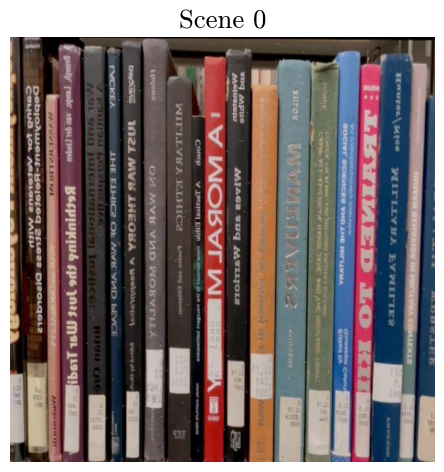

Processing scenes:   3%|▎         | 1/29 [00:02<01:13,  2.63s/it]

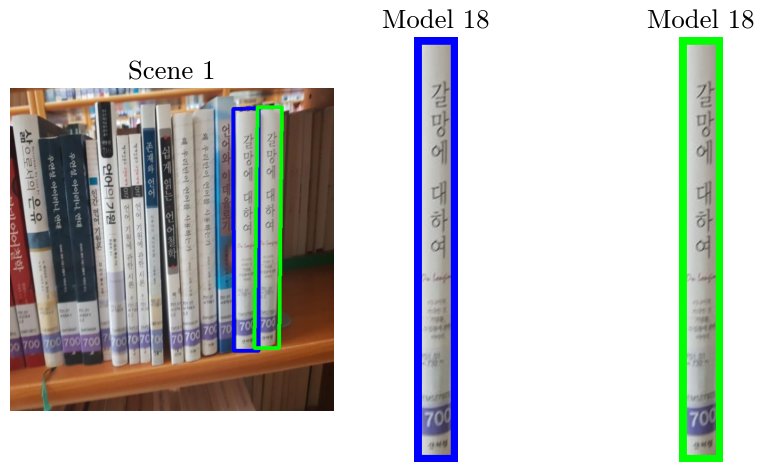

Processing scenes:   7%|▋         | 2/29 [00:06<01:24,  3.14s/it]

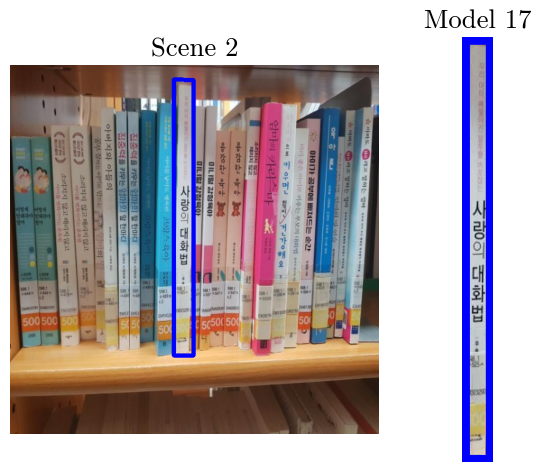

Processing scenes:  10%|█         | 3/29 [00:09<01:23,  3.21s/it]

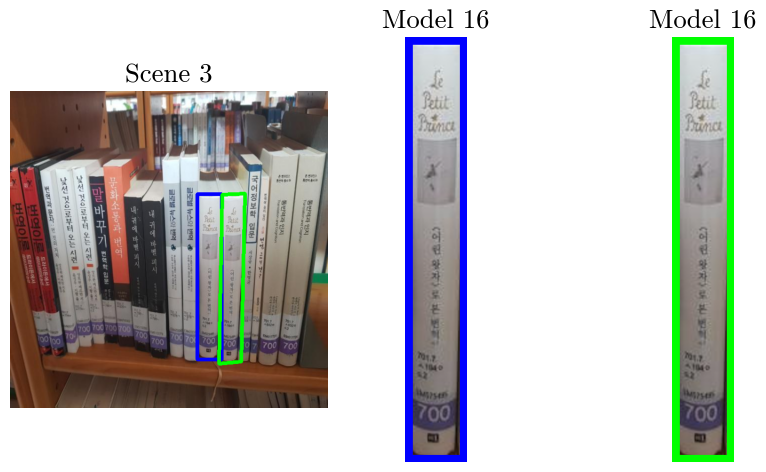

Processing scenes:  14%|█▍        | 4/29 [00:13<01:25,  3.42s/it]

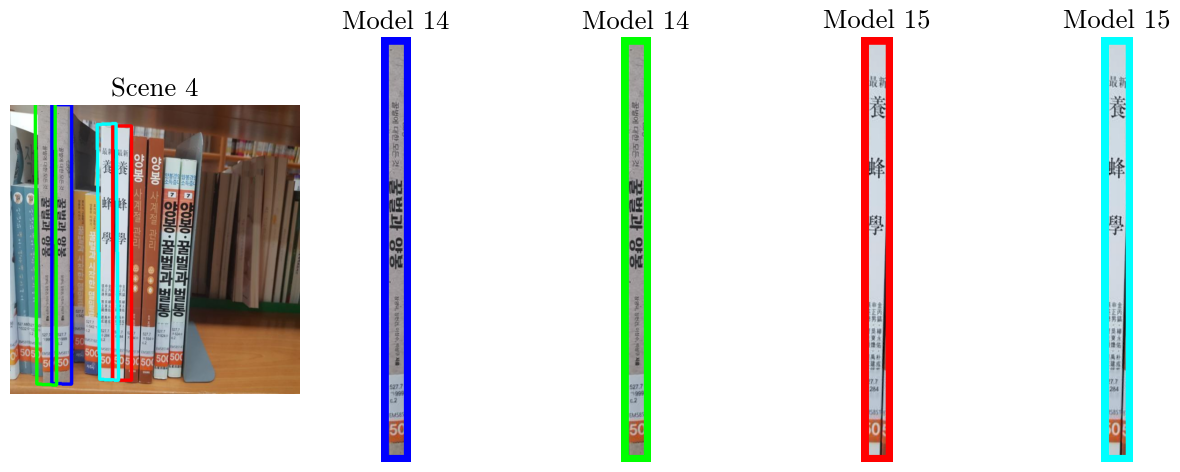

Processing scenes:  17%|█▋        | 5/29 [00:17<01:28,  3.71s/it]

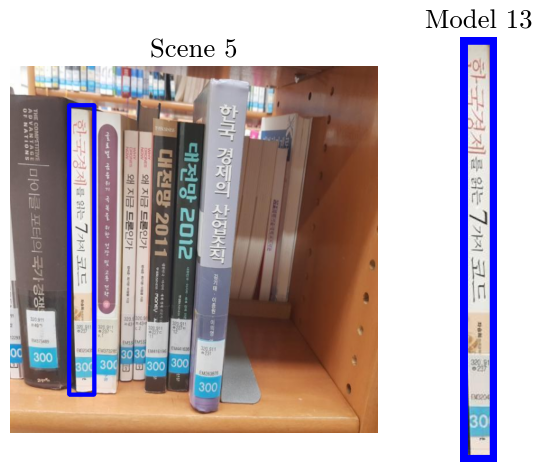

Processing scenes:  21%|██        | 6/29 [00:21<01:25,  3.72s/it]

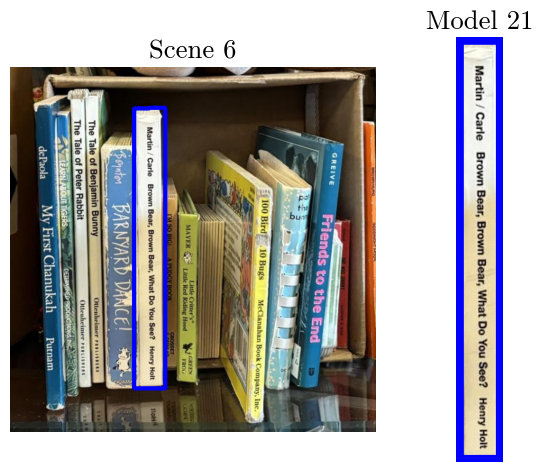

Processing scenes:  24%|██▍       | 7/29 [00:25<01:25,  3.90s/it]

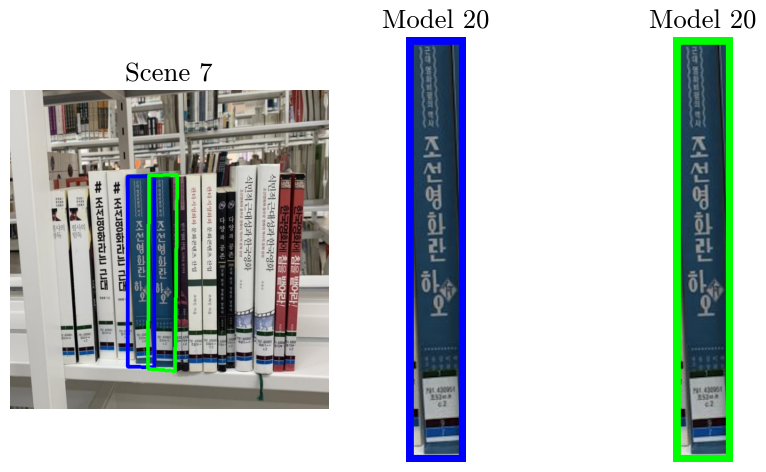

Processing scenes:  28%|██▊       | 8/29 [00:30<01:28,  4.19s/it]

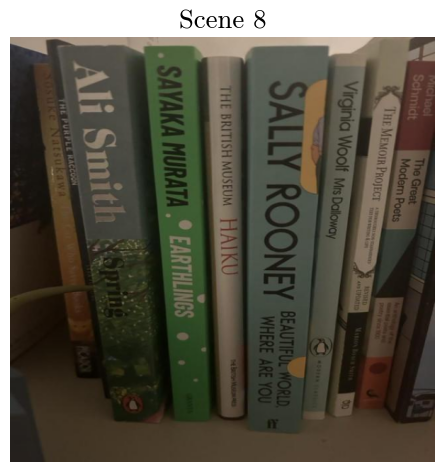

Processing scenes:  31%|███       | 9/29 [00:33<01:17,  3.87s/it]

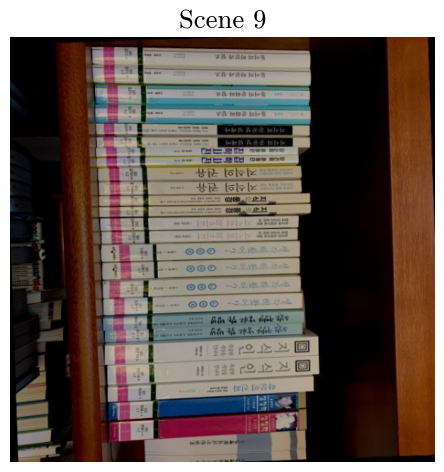

Processing scenes:  34%|███▍      | 10/29 [00:37<01:13,  3.86s/it]

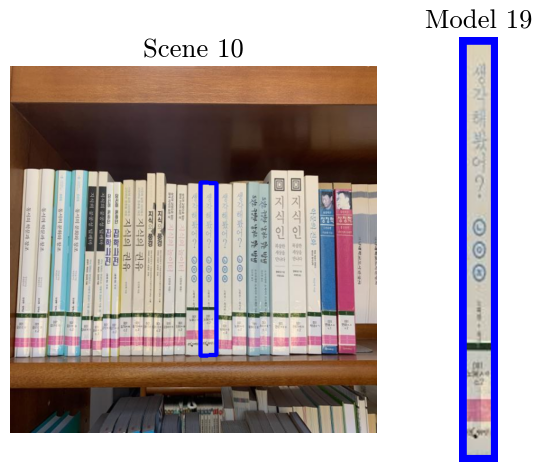

Processing scenes:  38%|███▊      | 11/29 [00:41<01:09,  3.86s/it]

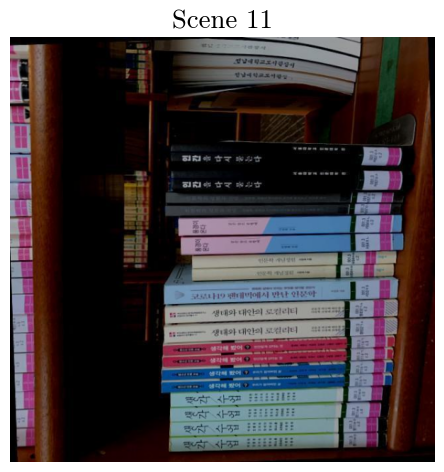

Processing scenes:  41%|████▏     | 12/29 [00:45<01:07,  3.97s/it]

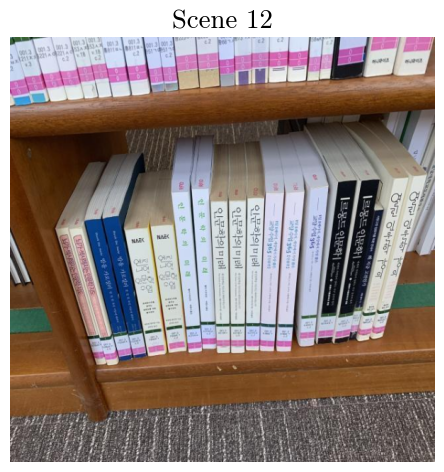

Processing scenes:  45%|████▍     | 13/29 [00:49<01:04,  4.06s/it]

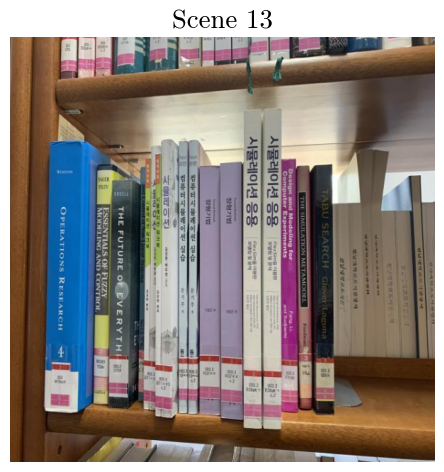

Processing scenes:  48%|████▊     | 14/29 [00:54<01:02,  4.18s/it]

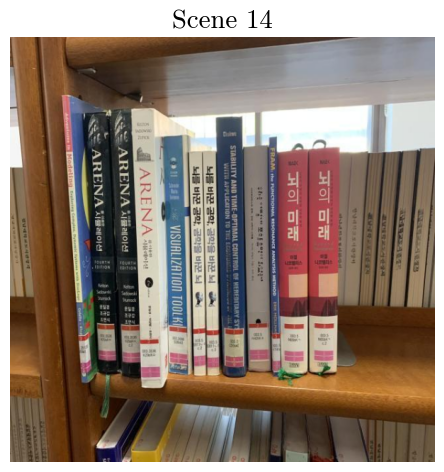

Processing scenes:  52%|█████▏    | 15/29 [00:58<00:59,  4.25s/it]

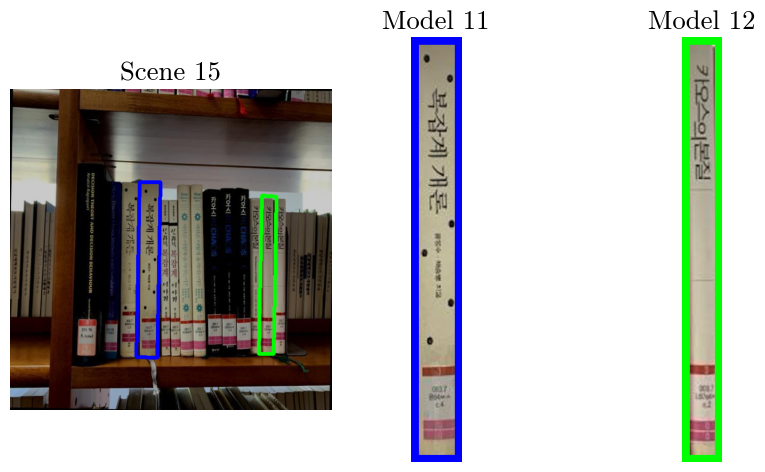

Processing scenes:  55%|█████▌    | 16/29 [01:02<00:56,  4.33s/it]

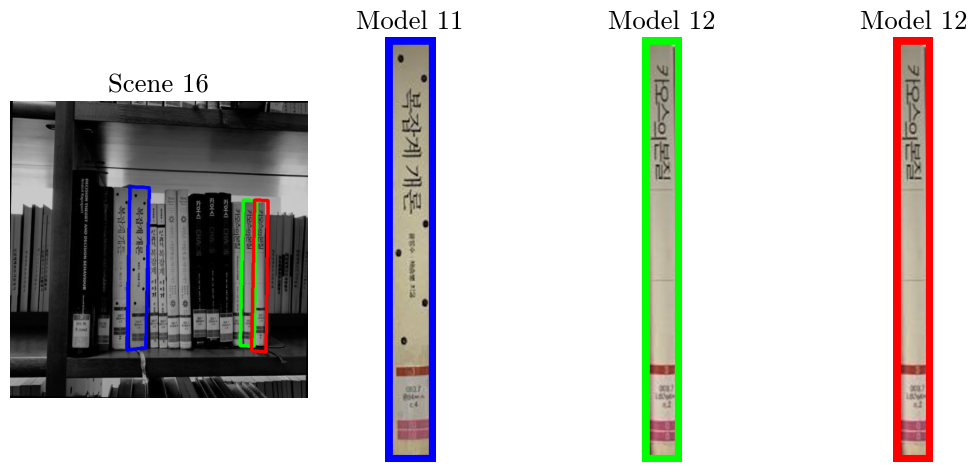

Processing scenes:  59%|█████▊    | 17/29 [01:07<00:52,  4.38s/it]

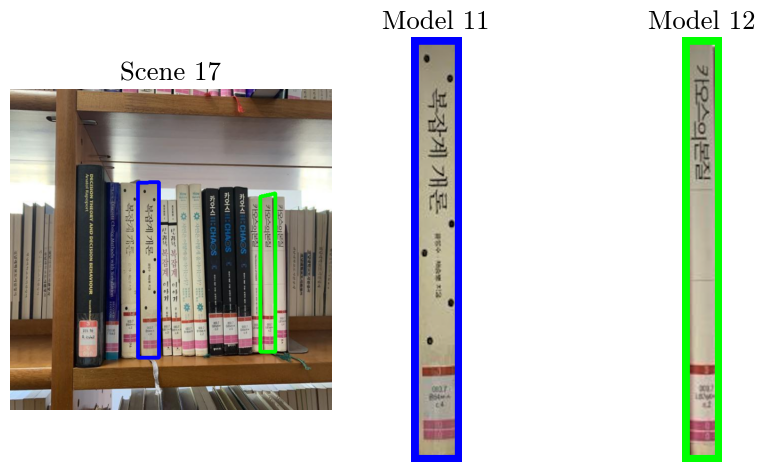

Processing scenes:  62%|██████▏   | 18/29 [01:11<00:47,  4.31s/it]

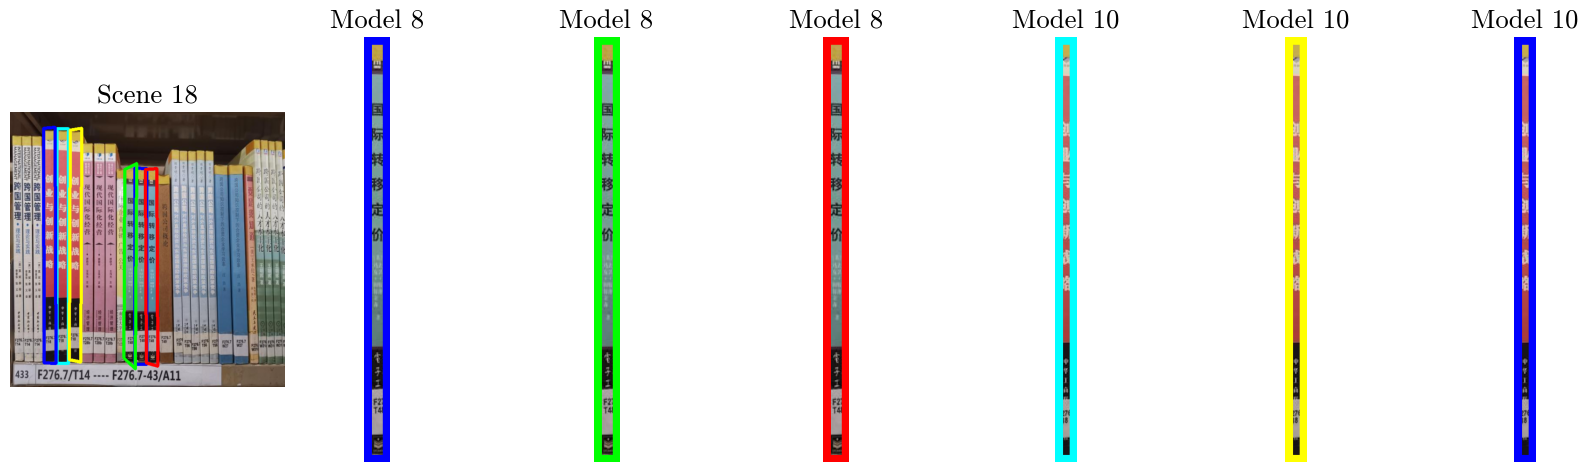

Processing scenes:  66%|██████▌   | 19/29 [01:17<00:48,  4.83s/it]

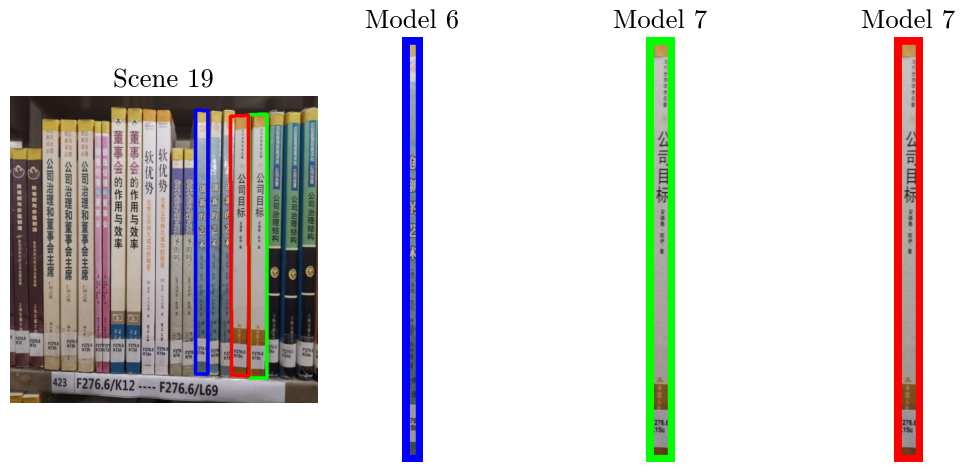

Processing scenes:  69%|██████▉   | 20/29 [01:23<00:45,  5.09s/it]

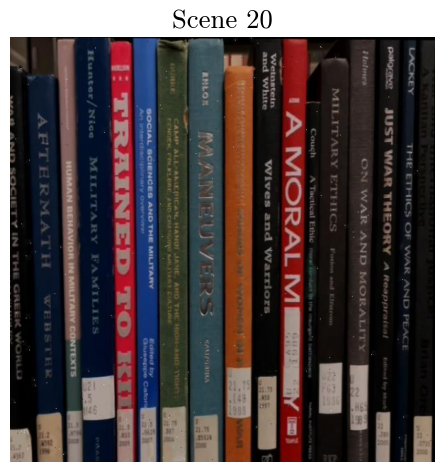

Processing scenes:  72%|███████▏  | 21/29 [01:28<00:40,  5.01s/it]

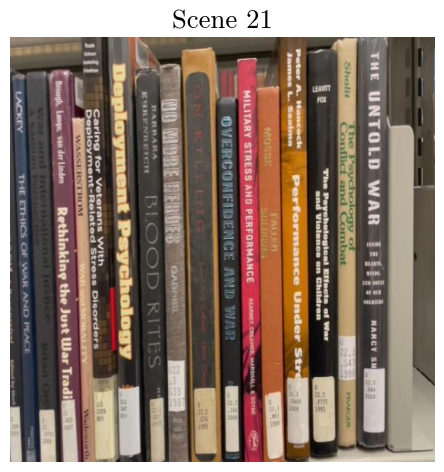

Processing scenes:  76%|███████▌  | 22/29 [01:33<00:36,  5.15s/it]

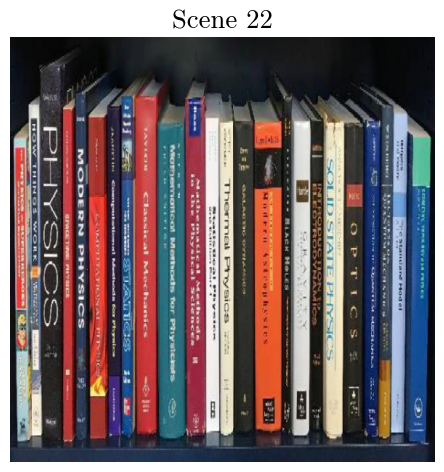

Processing scenes:  79%|███████▉  | 23/29 [01:38<00:29,  4.99s/it]

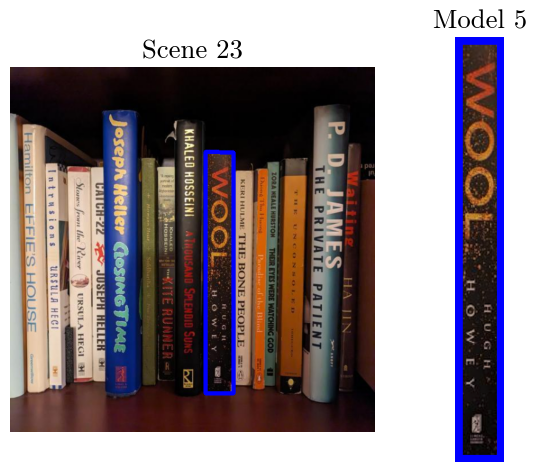

Processing scenes:  83%|████████▎ | 24/29 [01:42<00:24,  4.86s/it]

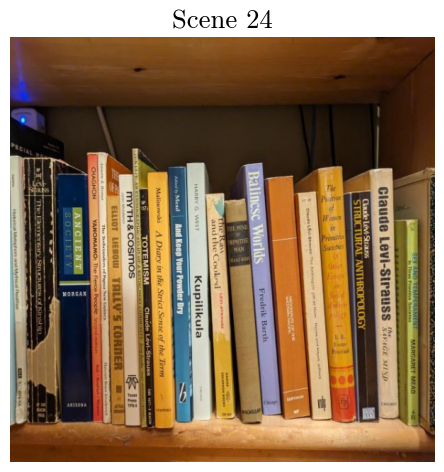

Processing scenes:  86%|████████▌ | 25/29 [01:47<00:18,  4.71s/it]

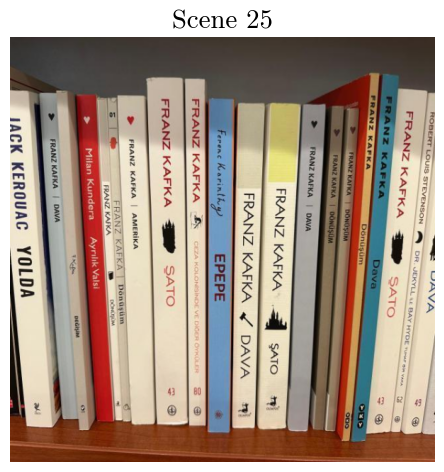

Processing scenes:  90%|████████▉ | 26/29 [01:51<00:13,  4.57s/it]

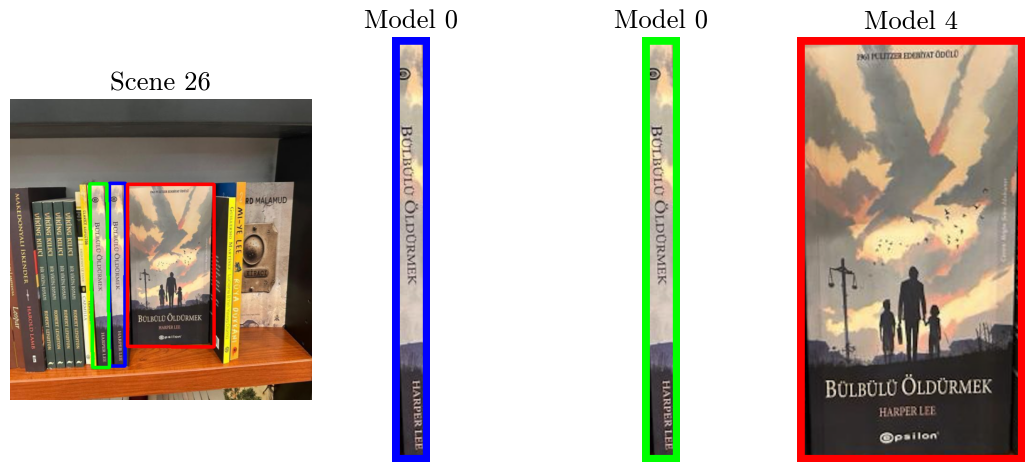

Processing scenes:  93%|█████████▎| 27/29 [01:55<00:09,  4.50s/it]

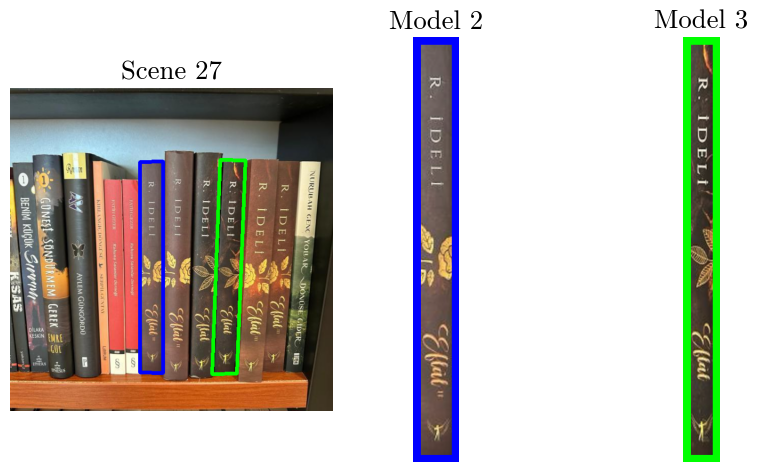

Processing scenes:  97%|█████████▋| 28/29 [01:59<00:04,  4.37s/it]

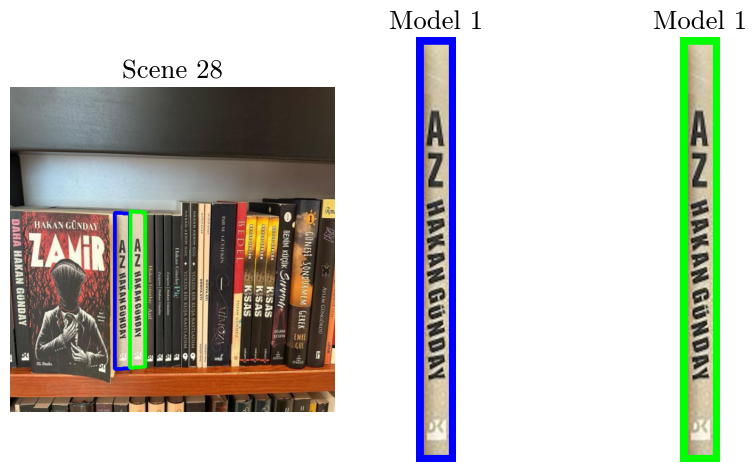

Processing scenes: 100%|██████████| 29/29 [02:04<00:00,  4.28s/it]


In [107]:
def preprocess_for_sift(gray):
    # Produce an aggressive preprocessing to enhance SIFT performance
    # Apply Gaussian blur to reduce noise and improve keypoint detection
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    # Apply histogram equalization to improve contrast
    equalized = cv2.equalizeHist(blurred)
    return equalized


DEBUG = False
for SCENE_IDX in tqdm(range(len(scenes_images)), desc="Processing scenes"):
    # SCENE_IDX = 27
    scenes_image = scenes_images[SCENE_IDX].copy()

    matches = []
    for idx, m in enumerate(models_images):
        model_image = m.copy()

        for i in range(10):
            scene_corners = instance_detect(
                scenes_image,
                model_image,
                preprocess=None,
                plot_matches=DEBUG,
                plot_rectangle=DEBUG,
                plot_descriptors=DEBUG,
                debug=DEBUG,
            )
            is_valid, reason = is_rectangle_valid(scene_corners)
            if DEBUG:
                print(
                    f"Model {idx}, Iteration {i}, Valid: {is_valid}, Reason: {reason}"
                )
            if not is_valid:
                break
            # Mask the detected area in the scene image to find another instance
            mask = np.zeros(scenes_image.shape[:2], dtype=np.uint8)

            matches.append((model_image, scene_corners, idx))
            cv2.fillPoly(mask, [np.int32(scene_corners)], (255))
            scenes_image = cv2.bitwise_and(
                scenes_image, scenes_image, mask=cv2.bitwise_not(mask)
            )
    plot_detections(scenes_images, matches, SCENE_IDX=SCENE_IDX)
    # break

## Evaluation criteria

1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.
